# Part 2 of notebook

## 5. Solution via augmented training set

Ideally, misclassification can be guarded against by adding many example images to the training set. Here, ~500 images of Dwayne Johnson were added to the training set, with the same 100 used above reserved for the validation set. The *net* and *dataloader* objects are rebuilt as above.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms, utils, datasets, models
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from helper_functions_clean import *

In [2]:
data_dir_dj = 'data/rps_augmented/'
class_names_dj, dataloaders_dj = get_data_loaders(data_dir_dj)
trainloader_dj = dataloaders_dj['train']
validloader_dj = dataloaders_dj['valid']

In [3]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)
        #self.sm = nn.LogSoftmax()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1)
       # x = self.sm(x)
        return x

net_dj = Net(len(class_names_dj))
net_dj.cuda() # the cuda method puts the net on the GPU. An nVidia GPU with the appropriate drivers is required.

Net(
  (conv1): Conv2d(3, 7, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(7, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_dj.parameters(), lr=0.001, momentum=0.9)

for epoch in range(100):
    
    running_loss = 0.0
    valid_loss = 0.0

    for i, data in enumerate(trainloader_dj, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        outputs = net_dj(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        
    for j, data in enumerate(validloader_dj, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        outputs = net_dj(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss.data[0]
        
    print('epoch: %d, loss: %.3f, valid loss: %.3f' % (epoch + 1, running_loss/(trainloader_dj.batch_size*i), valid_loss/(validloader_dj.batch_size*j)))


print('Finished Training')

epoch: 1, loss: 0.274, valid loss: 0.227
epoch: 2, loss: 0.242, valid loss: 0.240
epoch: 3, loss: 0.234, valid loss: 0.243
epoch: 4, loss: 0.224, valid loss: 0.197
epoch: 5, loss: 0.218, valid loss: 0.196
epoch: 6, loss: 0.203, valid loss: 0.171
epoch: 7, loss: 0.199, valid loss: 0.163
epoch: 8, loss: 0.197, valid loss: 0.186
epoch: 9, loss: 0.187, valid loss: 0.174
epoch: 10, loss: 0.184, valid loss: 0.184
epoch: 11, loss: 0.176, valid loss: 0.150
epoch: 12, loss: 0.176, valid loss: 0.143
epoch: 13, loss: 0.176, valid loss: 0.212
epoch: 14, loss: 0.174, valid loss: 0.154
epoch: 15, loss: 0.175, valid loss: 0.149
epoch: 16, loss: 0.173, valid loss: 0.176
epoch: 17, loss: 0.168, valid loss: 0.192
epoch: 18, loss: 0.158, valid loss: 0.155
epoch: 19, loss: 0.162, valid loss: 0.195
epoch: 20, loss: 0.164, valid loss: 0.149
epoch: 21, loss: 0.157, valid loss: 0.127
epoch: 22, loss: 0.175, valid loss: 0.156
epoch: 23, loss: 0.175, valid loss: 0.149
epoch: 24, loss: 0.156, valid loss: 0.133
e

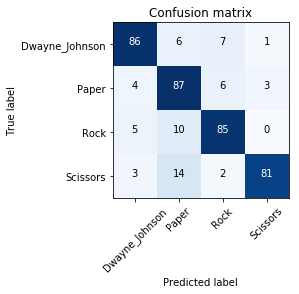

In [5]:
ground_truth_dj, probability_list_base_classes_dj, prediction_dj = prediction_list(validloader_dj, net_dj)
cnf_matrix = confusion_matrix(ground_truth_dj, prediction_dj)
plot_confusion_matrix(cnf_matrix, class_names_dj)

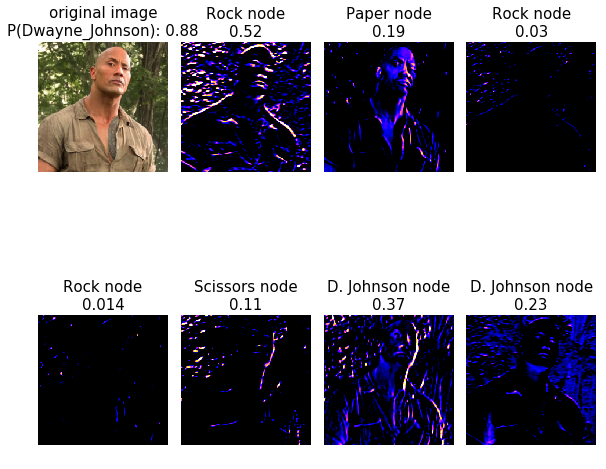

In [6]:
modulelist_dj = list(net_dj.modules())[1:]
valid_path_dj = data_dir_dj + 'valid/' + '{}/'
layer_activation_strength_dj, strongest_activator_dj = layers_by_classification(valid_path_dj, class_names_dj, net_dj, 1)
strongest_activator_dj = ['D. Johnson' if item == 'Dwayne_Johnson' else item for item in strongest_activator_dj]

im_path = 'data/rps_augmented/valid/Dwayne_Johnson/pic_009.jpg'
plot_first_layer_with_strongest_activator(im_path, modulelist_dj[0], strongest_activator_dj, net_dj, class_names_dj)

It is good to verify that broadening our training set mostly fixes the misclassification issue. However, this is not always feasible, and there will always be examples of outlier images that can "fool" an image classifier.